[![Open in GitHub Codespaces](https://github.com/codespaces/badge.svg)](https://codespaces.new/swiftsoftwaregroup/tropess-notes-python) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/swiftsoftwaregroup/tropess-notes-python/blob/main/book/data-analysis-carbon-monoxide-plot-levels.ipynb) [![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/swiftsoftwaregroup/tropess-notes-python/blob/main/book/data-analysis-carbon-monoxide-plot-levels.ipynb)

# Carbon Monoxide at select pressure levels (CO)

Create scatter plots of Carbon Monoxide (CO) concentration retrieved at different pressure levels from [CrIS JPSS-1](https://www.nesdis.noaa.gov/current-satellite-missions/currently-flying/joint-polar-satellite-system/cross-track-infrared) global observations.

## Import packages

In [7]:
import numpy as np

from netCDF4 import Dataset

import metpy.calc as mpcalc
from metpy.units import units

import matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Read data variables

The `x` variable is volume mixing ratio (VMR) of Carbon Monoxide relative to dry air at different pressure levels - May 16th, 2023. 

In [8]:
# Open the netCDF file
dataset = Dataset('./data/TROPESS_CrIS-JPSS1_L2_Standard_CO_20230516_MUSES_R1p20_FS_F0p6.nc', 'r')

# Read the data from variables
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]

x_all = dataset.variables['x'][:]
pressure = dataset.variables['pressure'][:]

dataset.close()

## Create plots

Create plots for a few pressure levels higher than 261 hPa (11km and lower altitude), in ppbv.

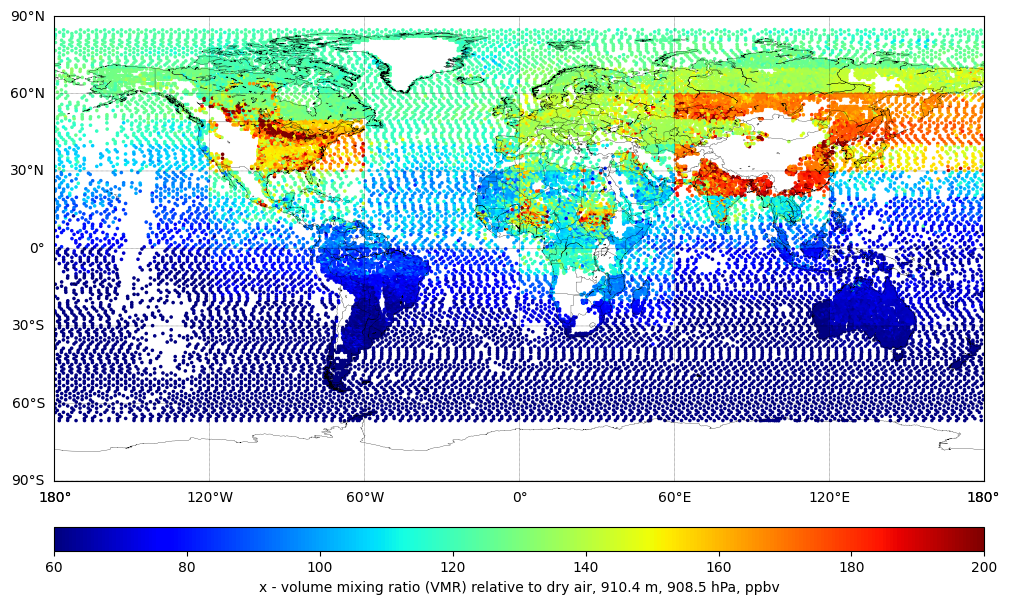

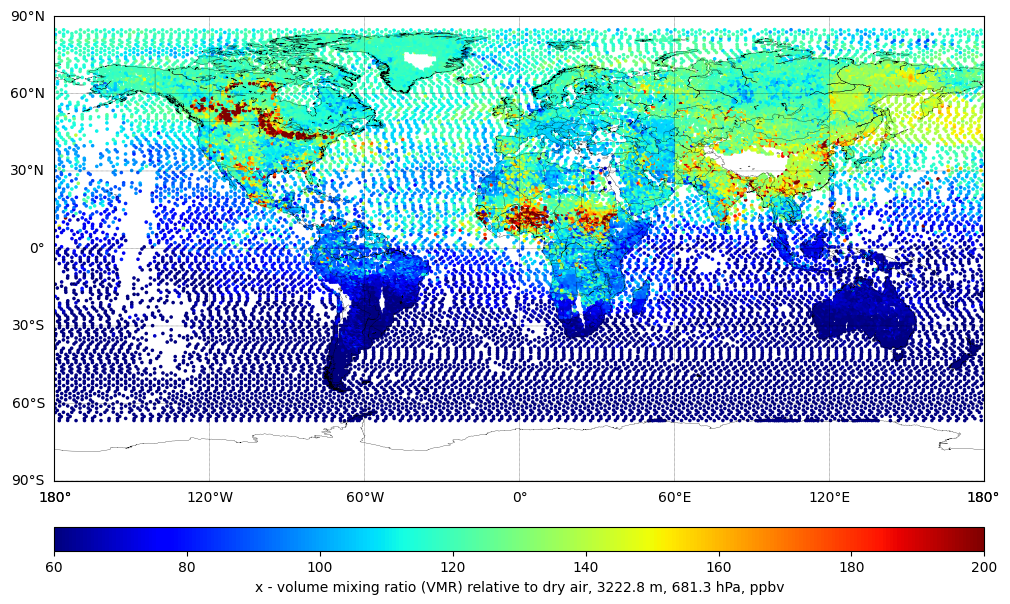

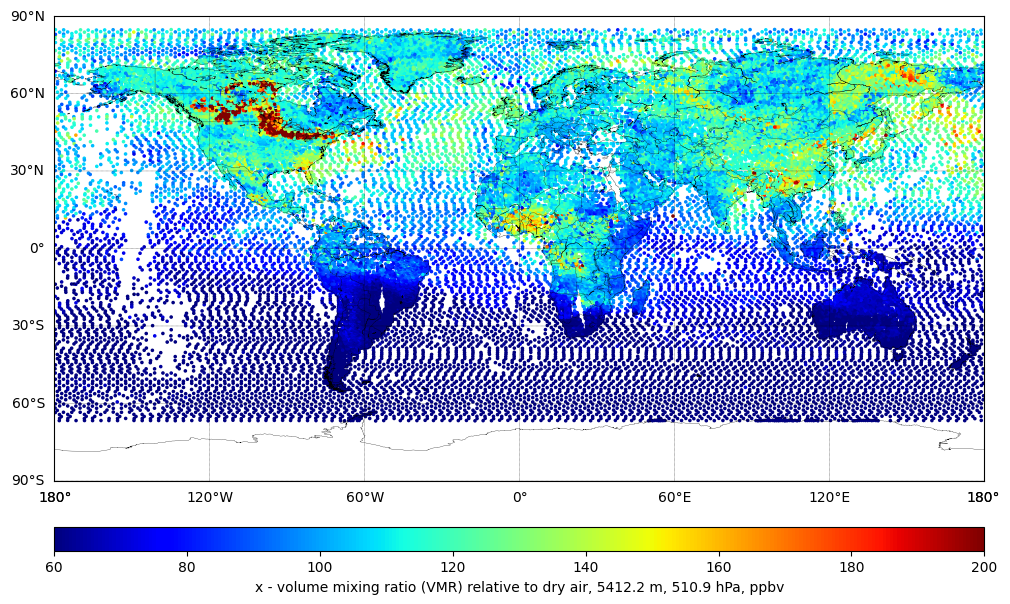

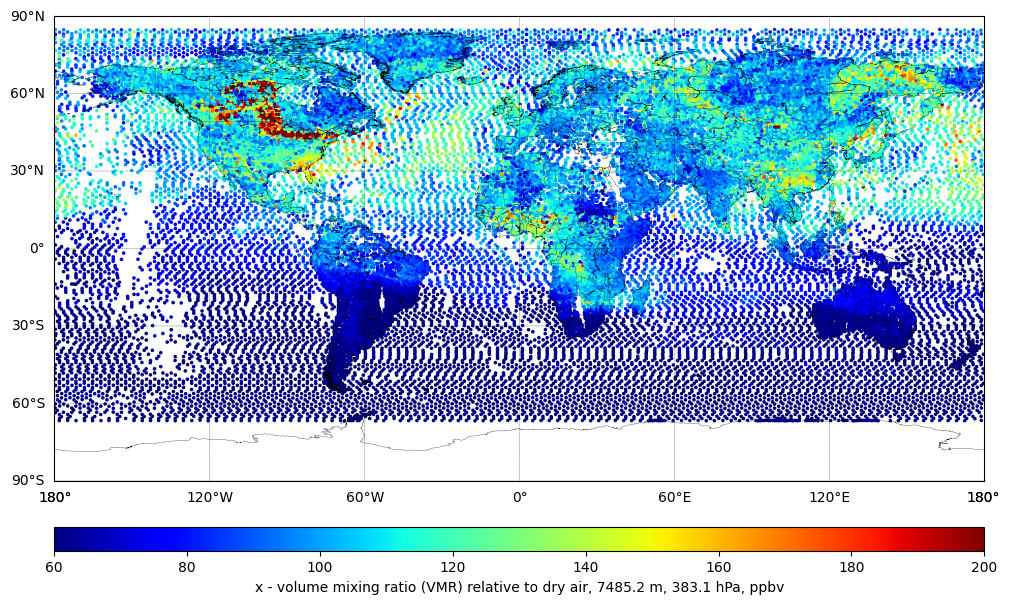

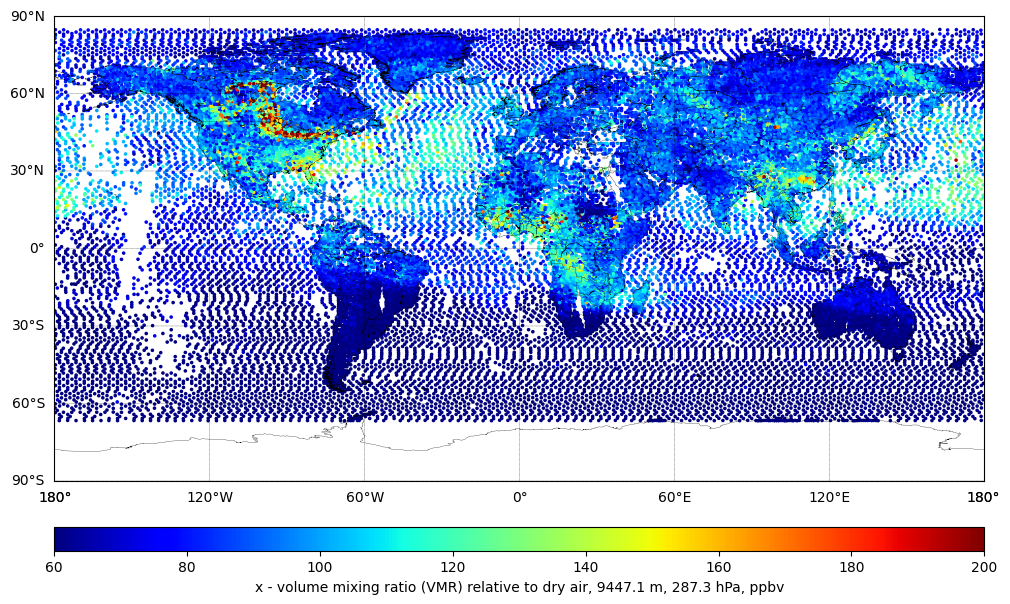

In [9]:
# Convert x_all to parts per billion
x_all = x_all * 1e9

#  These were taken from the CO product user guide 
standard_pressure = [
    1040.0000, 908.5139, 681.2910, 510.8980, 
    383.1170, 287.2980, 215.4440, 161.5610, 121.1520, 
    90.8518, 51.0896, 28.7299, 4.6416, 0.1000 
]


# Round pressure levels so that we can match specfic pressures later 
rounded_pressure = np.around(pressure, decimals=1)
rounded_standard_pressure = np.around(standard_pressure, decimals=1)

# Compute the altitudes (in km)
# see: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.pressure_to_height_std.html
standard_altitude = mpcalc.pressure_to_height_std(rounded_standard_pressure * units.hPa).m_as(units.meters)
rounded_standard_altitude = np.around(standard_altitude, decimals=1)

# select levels below 11km
below_11km = np.where(rounded_standard_altitude <= 11000)[0]
rounded_standard_pressure = rounded_standard_pressure[below_11km]

# Plot each pressure level
for pressure_1 in rounded_standard_pressure:
    # Select data points at the specific pressure level
    pressure_index = np.where(rounded_pressure == pressure_1)

    # skip if empty
    if pressure_index[0].size == 0 and pressure_index[1].size == 0:
        continue

    # filter data
    x_level = x_all[ pressure_index[0], pressure_index[1] ]
    latitude_level = latitude[ pressure_index[0] ]
    longitude_level = longitude[ pressure_index[0] ]

    # Get corresponding altitude
    altitude_index = np.where(rounded_standard_pressure == pressure_1)[0]
    altitude_1 = rounded_standard_altitude[altitude_index][0]

    # Specify figure size (in inches)
    plt.figure(figsize=(12, 8))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l', 
                llcrnrlat=-90, urcrnrlat=90,  # set latitude limits to -90 and 90
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and 180

    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)

    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-90., 91., 30.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 60.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

    # Standard catter plot
    # Transform lat and lon to map projection coordinates
    x, y = m(longitude_level, latitude_level)

    # Plot the data using scatter (you may want to choose a different colormap and normalization)
    sc = m.scatter(x, y, c=x_level, cmap='jet', marker='.', s=10, vmin=60.0, vmax=200.0)

    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label(f'x - volume mixing ratio (VMR) relative to dry air, {altitude_1} m, {pressure_1} hPa, ppbv')

    # show the plot
    plt.show()